In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
from maxwellbloch import hyperfine

Rb87_5s12_F1 = hyperfine.LevelF(I=1.5, J=0.5, F=1)
Rb87_5s12_F2 = hyperfine.LevelF(I=1.5, J=0.5, F=2) # Needed for decay

Rb87_5p12_F1 = hyperfine.LevelF(I=1.5, J=0.5, F=1)

atom1e = hyperfine.Atom1e(element='Rb', isotope='87')

atom1e.add_F_level(Rb87_5s12_F1)
atom1e.add_F_level(Rb87_5s12_F2)
atom1e.add_F_level(Rb87_5p12_F1)

In [4]:
NUM_STATES = atom1e.get_num_mF_levels()
print(NUM_STATES)

11


In [5]:
ENERGIES = atom1e.get_energies()
print(ENERGIES)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [6]:
# Tune to be on resonance with the F1 -> F1 transition
DETUNING = 0
print(DETUNING)

0


In [7]:
FIELD_CHANNELS = atom1e.get_coupled_levels(F_level_idxs_a=(0,), F_level_idxs_b=(2,))
print(FIELD_CHANNELS)

[[0, 8], [0, 9], [0, 10], [1, 8], [1, 9], [1, 10], [2, 8], [2, 9], [2, 10]]


In [8]:
q = 1 # Field polarisation
FIELD_FACTORS = atom1e.get_clebsch_hf_factors(F_level_idxs_a=(0,), F_level_idxs_b=(2,), q=q)
print(FIELD_FACTORS)

[ 0.          0.          0.          0.28867513 -0.         -0.
  0.          0.28867513  0.        ]


In [9]:
strength_factor = np.sum(FIELD_FACTORS**2)
print(strength_factor)

0.16666666666666657


1/6 is the strength factor S_11

In [10]:
hf_factor = np.max(FIELD_FACTORS)
print(hf_factor)

0.2886751345948128


In [11]:
DECAY_CHANNELS = atom1e.get_coupled_levels(F_level_idxs_a=(0,1), F_level_idxs_b=(2,))
print(DECAY_CHANNELS)

[[0, 8], [0, 9], [0, 10], [1, 8], [1, 9], [1, 10], [2, 8], [2, 9], [2, 10], [3, 8], [3, 9], [3, 10], [4, 8], [4, 9], [4, 10], [5, 8], [5, 9], [5, 10], [6, 8], [6, 9], [6, 10], [7, 8], [7, 9], [7, 10]]


In [12]:
DECAY_FACTORS = atom1e.get_decay_factors(F_level_idxs_a=(0, 1), F_level_idxs_b=(2,))
print(DECAY_FACTORS)

[ 0.28867513 -0.28867513  0.          0.28867513 -0.         -0.28867513
  0.          0.28867513 -0.28867513  0.70710678  0.          0.
  0.5         0.5        -0.          0.28867513  0.57735027  0.28867513
 -0.          0.5         0.5         0.          0.          0.70710678]


In [13]:
INITIAL_STATE = (
    [1.0/3.0]*3 + # s12_F1
    [0.0/5.0]*5 + # s12_F2
    [0.0]*3) # p12_F1    
print(INITIAL_STATE)

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [14]:
sech_fwhm_conv = 1./2.6339157938
WIDTH = 1.0*sech_fwhm_conv # [τ]
print('WIDTH', WIDTH)

n = 4.0 # For a pulse area of nπ    
AMPL = n/WIDTH/(2*np.pi) # Pulse amplitude [2π Γ]

AMPL *= 1/hf_factor

print('ampl', AMPL)

WIDTH 0.3796628587572578
ampl 5.808615540919067


In [15]:
mb_solve_json = """
{{
  "atom": {{
    "decays": [
      {{
        "channels": {decay_channels},
        "rate": 0.0,
        "factors": {decay_factors}
      }}
    ],
    "energies": {energies},
    "fields": [
      {{
        "coupled_levels": {field_channels},
        "factors": {field_factors},
        "detuning": {detuning},
        "detuning_positive": true,
        "label": "probe",
        "rabi_freq": 1.0,
        "rabi_freq_t_args": {{
          "ampl": {ampl},
          "centre": 0.0,
          "width": {width}
        }},
        "rabi_freq_t_func": "sech"
      }}
    ],
    "num_states": {num_states},
    "initial_state": {initial_state}
  }},
  "t_min": -2.0,
  "t_max": 10.0,
  "t_steps": 100,
  "z_min": -0.5,
  "z_max": 1.5,
  "z_steps": 100,
  "z_steps_inner": 1,
  "num_density_z_func": "square",
  "num_density_z_args": {{
    "on": 0.0,
    "off": 1.0,
    "ampl": 1.0
  }},
  "interaction_strengths": [
    5.0e2
  ],
  "velocity_classes": null,
  "method": "mesolve",
  "opts": {{
    "method": "bdf", 
    "atol": 1e-8, 
    "rtol": 1e-6,
    "nsteps": 1e2
  }},
  "savefile": "qu/mbs-Rb87_5s12_5p12_F11_q1-sech-4pi"
}}
""".format(num_states=NUM_STATES, energies=ENERGIES, initial_state=INITIAL_STATE, 
           detuning=DETUNING, field_channels=FIELD_CHANNELS, field_factors=list(FIELD_FACTORS), 
           decay_channels=DECAY_CHANNELS, decay_factors=list(DECAY_FACTORS),
           ampl=AMPL, width=WIDTH)

In [16]:
from maxwellbloch import mb_solve
mbs = mb_solve.MBSolve().from_json_str(mb_solve_json)

In [17]:
%time Omegas_zt, states_zt = mbs.mbsolve(recalc=True, pbar_chunk_size=10)

10.0%. Run time:   3.28s. Est. time left: 00:00:00:29
20.0%. Run time:   6.26s. Est. time left: 00:00:00:25
30.0%. Run time:   9.23s. Est. time left: 00:00:00:21
40.0%. Run time:  12.79s. Est. time left: 00:00:00:19
50.0%. Run time:  16.83s. Est. time left: 00:00:00:16
60.0%. Run time:  20.98s. Est. time left: 00:00:00:13
70.0%. Run time:  25.57s. Est. time left: 00:00:00:10
80.0%. Run time:  30.16s. Est. time left: 00:00:00:07
90.0%. Run time:  34.77s. Est. time left: 00:00:00:03
Total run time:  39.40s
Saving MBSolve to qu/mbs-Rb87_5s12_5p12_F11_q1-sech-4pi.qu
Wall time: 39.6 s


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_style('darkgrid')

import numpy as np

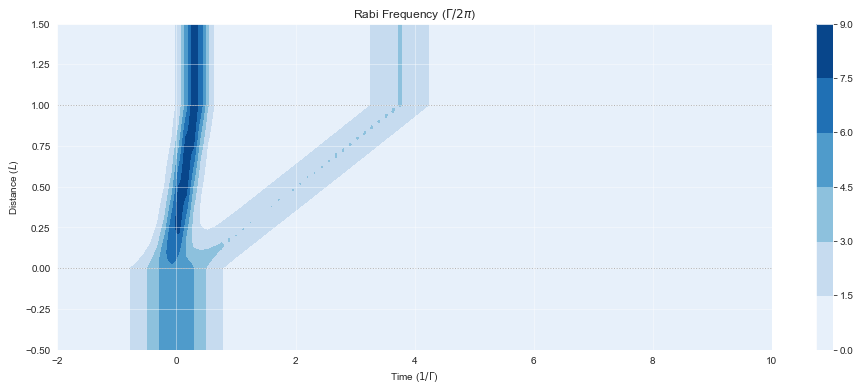

In [19]:
fig = plt.figure(1, figsize=(16, 6))
ax = fig.add_subplot(111)
# cmap_range = np.linspace(0.0, 12, 11)
cf = ax.contourf(mbs.tlist, mbs.zlist, 
                 np.abs(mbs.Omegas_zt[0]/(2*np.pi)),
#                  cmap_range,
                 cmap=plt.cm.Blues
                )
ax.set_title('Rabi Frequency ($\Gamma / 2\pi $)')
ax.set_xlabel('Time ($1/\Gamma$)')
ax.set_ylabel('Distance ($L$)')
ax.grid(alpha=0.5)
ax.set_axisbelow(False)
for y in [0.0, 1.0]:
    ax.axhline(y, c='grey', lw=1.0, ls='dotted')
plt.colorbar(cf);

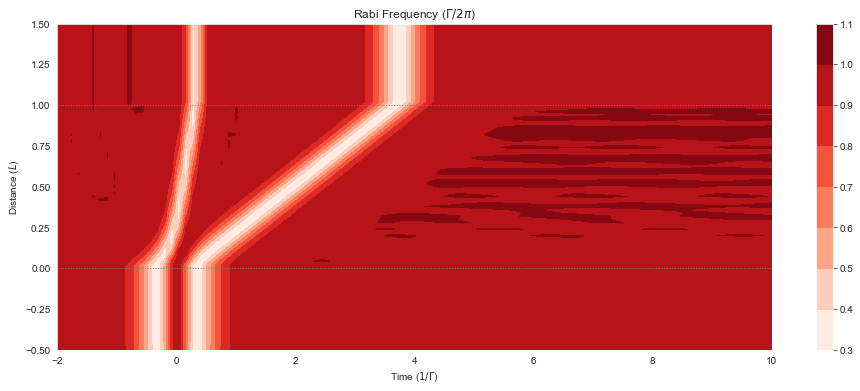

In [20]:
fig = plt.figure(1, figsize=(16, 6))
ax = fig.add_subplot(111)
# cmap_range = np.linspace(0.0, 1.0e-3, 11)
cf = ax.contourf(mbs.tlist, mbs.zlist, 
                 np.abs(mbs.populations_field(0, upper=False)),
#                  cmap_range, 
                 cmap=plt.cm.Reds
                )
ax.set_title('Rabi Frequency ($\Gamma / 2\pi $)')
ax.set_xlabel('Time ($1/\Gamma$)')
ax.set_ylabel('Distance ($L$)')
for y in [0.0, 1.0]:
    ax.axhline(y, c='grey', lw=1.0, ls='dotted')
plt.colorbar(cf);

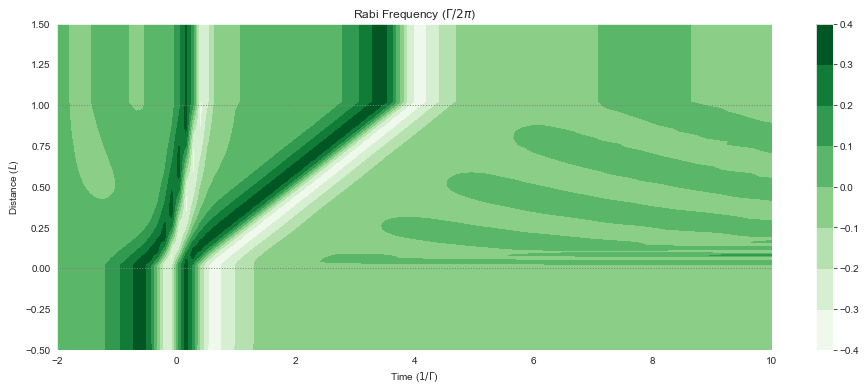

In [21]:
fig = plt.figure(1, figsize=(16, 6))
ax = fig.add_subplot(111)
# cmap_range = np.linspace(0.0, 1.0e-3, 11)
cf = ax.contourf(mbs.tlist, mbs.zlist, 
                 np.imag(mbs.coherences_field(0)),
#                  cmap_range, 
                 cmap=plt.cm.Greens
                )
ax.set_title('Rabi Frequency ($\Gamma / 2\pi $)')
ax.set_xlabel('Time ($1/\Gamma$)')
ax.set_ylabel('Distance ($L$)')
for y in [0.0, 1.0]:
    ax.axhline(y, c='grey', lw=1.0, ls='dotted')
plt.colorbar(cf);